In [1]:
#| echo: false

# Last updated
from datetime import datetime
from IPython import display

display.Markdown(f"*Last update: {datetime.today().strftime('%Y-%m-%d')}*")

*Last update: 2024-04-04*

In [2]:
#| echo: false

import numpy as np
import pandas as pd
import seaborn as sns

from constants import SEED
from datasets import PlanetClear
from workflow.prepare_data import make_splits, load_db_imputed

# Introduction

The purpose of this notebook is to create train / val / test splits that satisfy two criteria:

1. Consistent across datasets i.e. same station-days used for training when using no images, `RGB`, `TOAR` and `ATM` data
2. Similar distributions i.e. the distribution of `pm10` values is similar in the train, val, and test data

@fig-bad-splits shows an example of splits that are not consistent across datasets and air quality measures contain outliers. The `RGB` validation and test sets contain fewer very high OP~DTT~ measures than the `TOAR` validation and test sets. This would make it hard to compare performance metrics (e.g. RMSE) of models trained on different datasets, especially since the datasets are fairly small (<370 points for OP~DTT~). Also, the `RGB` and `TOAR` train set contains an outlier with unusually high OP~DTT~ (> 6 nmol min^-1^ m^-3^). This point might have a strong influence on the error of the predictions, especially squared error.

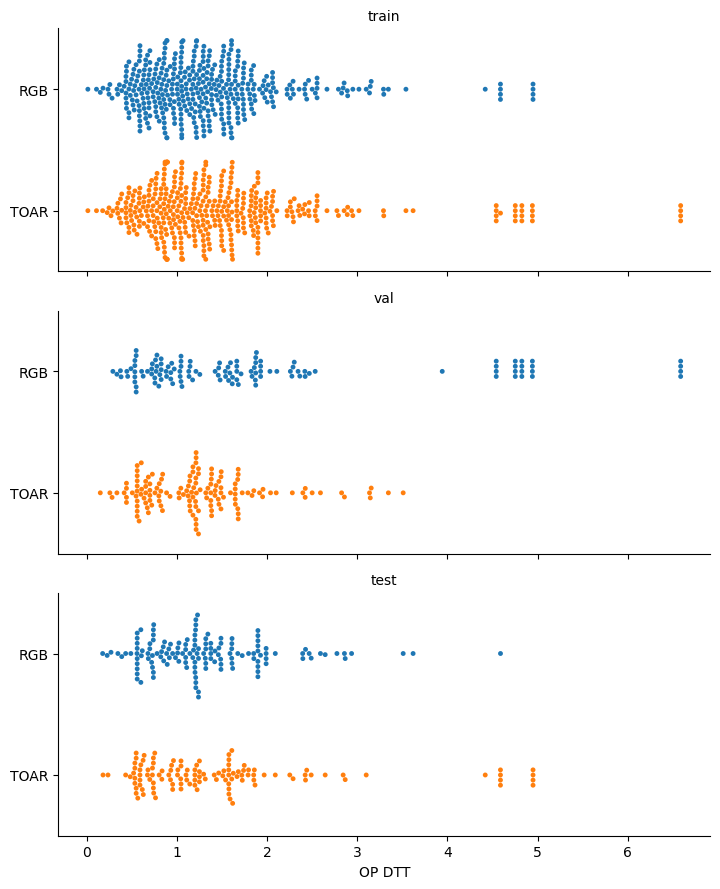

In [3]:
#| label: fig-bad-splits
#| fig-cap: "Distribution of OP~DTT~ in dataset-specific train / val / test splits"

# Get RGB and TOAR labels
# fmt: off
label_cols = ["data_type", "instrument", "date", "station", "pm10", "pm10_imp",
              "op_aa25_m3", "op_dtt25_m3"]
# fmt: on
rgb_labels = pd.concat(
    [
        PlanetClear("RGB", "PS2").labels[label_cols],
        PlanetClear("RGB", "PS2.SD").labels[label_cols],
        PlanetClear("RGB", "PSB.SD").labels[label_cols],
    ]
)
toar_labels = pd.concat(
    [
        PlanetClear("TOAR", "PS2").labels[label_cols],
        PlanetClear("TOAR", "PS2.SD").labels[label_cols],
        PlanetClear("TOAR", "PSB.SD").labels[label_cols],
    ]
)

# Split per dataset
split_params = {
    "test_frac": 0.2,
    "val_frac": 0.2,
    "shuffle": True,
    "groups": "date",
    "rand_seed": SEED,
}
rgb_splits = make_splits(rgb_labels, **split_params)
toar_splits = make_splits(toar_labels, **split_params)
split_per_dataset = pd.concat(
    [
        rgb_labels.join(rgb_splits, on=["date", "station"]),
        toar_labels.join(toar_splits, on=["date", "station"]),
    ]
)

p = (
    sns.catplot(
        split_per_dataset.query(f"op_dtt25_m3.notna()"),
        x="op_dtt25_m3",
        y="data_type",
        row="set",
        hue="data_type",
        kind="swarm", size=3.5, aspect=2.5, height=3
    )
    .set_titles("{row_name}")
    .set_axis_labels(x_var="OP DTT", y_var="")
)

# Uniform splits

To avoid these issues, we create uniform splits that assign each station-day to the train, val, or test set. This ensures that the distribution of air quality measures in the train set is the same across the `RGB`, `TOAR`, and `ATM` datasets.

@fig-splits-pm10, @fig-splits-aa, and @fig-splits-dtt show the distribution of air quality measures across uniform train, val, and test sets. While the distribution of air quality is now consistent across datasets, there are still outliers that may have a disproportionate impact on our evaluation metrics (e.g. RMSE). For example, the test set contains an outlier with PM~10~ > 80 µg/m^3^ but the vast majority of PM~10~ measures are < 50 µg/m^3^.

In [4]:
# Make splits from db so that station-days without images are assigned a split
db_labels = (
    load_db_imputed()[["pm10", "pm10_imp", "op_aa25_m3", "op_dtt25_m3"]]
    .assign(data_type="Measures")
    .reset_index()
)
db_labels = db_labels.loc[db_labels["station"].isin(rgb_labels["station"].unique()), :]
splits = make_splits(
    labels=db_labels,
    test_frac=0.2,
    val_frac=0.2,
    shuffle=True,
    groups="date",
    rand_seed=SEED,
)

# Get ATM labels
atm_labels = pd.concat(
    [
        PlanetClear("ATM", "PS2").labels[rgb_labels.columns],
        PlanetClear("ATM", "PS2.SD").labels[rgb_labels.columns],
        PlanetClear("ATM", "PSB.SD").labels[rgb_labels.columns],
    ]
)

# Join splits with labels
data_split = pd.concat(
    [
        db_labels.join(splits, on=["date", "station"]),
        rgb_labels.join(splits, on=["date", "station"]),
        toar_labels.join(splits, on=["date", "station"]),
        atm_labels.join(splits, on=["date", "station"]),
    ]
)

## PM~10~

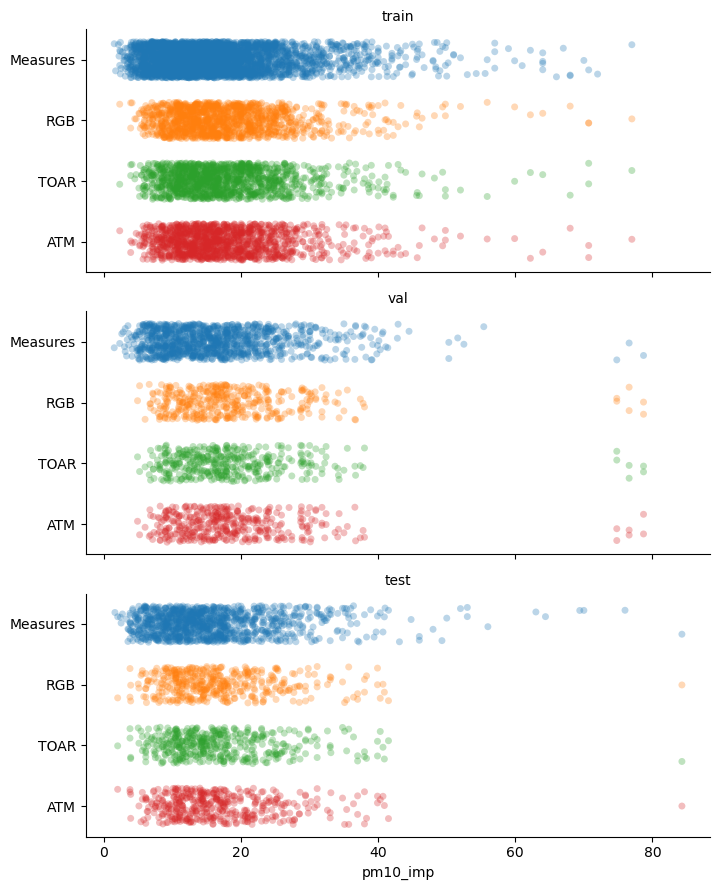

In [5]:
#| label: fig-splits-pm10
#| fig-cap: "Distribution of PM~10~ in uniform train / val / test sets"

target = "pm10_imp"
np.random.seed(SEED)
p = (
    sns.catplot(
        data_split.query(f"{target}.notna()"),
        x=target,
        y="data_type",
        row="set",
        hue="data_type",
        kind="strip", jitter=0.3, alpha=0.3, aspect=2.5, height=3
    )
    .set_titles("{row_name}")
    .set_axis_labels(y_var="")
)

## OP~AA~

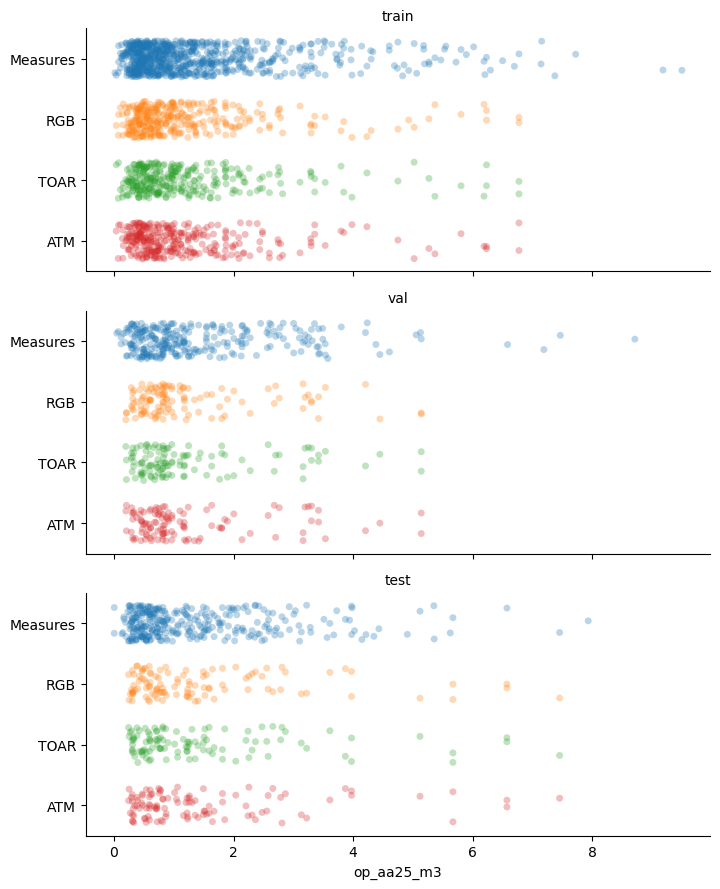

In [6]:
#| label: fig-splits-aa
#| fig-cap: "Distribution of OP~AA~ in uniform train / val / test sets"

target = "op_aa25_m3"
np.random.seed(SEED)
p = (
    sns.catplot(
        data_split.query(f"{target}.notna()"),
        x=target,
        y="data_type",
        row="set",
        hue="data_type",
        kind="strip", jitter=0.3, alpha=0.3, aspect=2.5, height=3
    )
    .set_titles("{row_name}")
    .set_axis_labels(y_var="")
)

## OP~DTT~

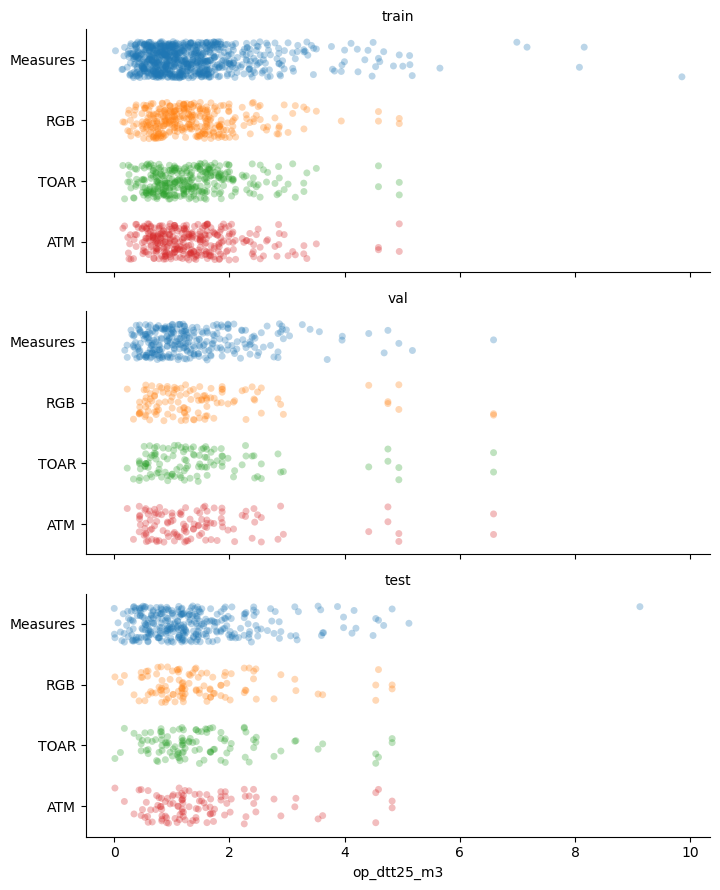

In [7]:
#| label: fig-splits-dtt
#| fig-cap: "Distribution of OP~DTT~ in uniform train / val / test sets"

target = "op_dtt25_m3"
np.random.seed(SEED)
p = (
    sns.catplot(
        data_split.query(f"{target}.notna()"),
        x=target,
        y="data_type",
        row="set",
        hue="data_type",
        kind="strip", jitter=0.3, alpha=0.3, aspect=2.5, height=3
    )
    .set_titles("{row_name}")
    .set_axis_labels(y_var="")
)

# Uniform no outliers

To minimize differences between the train, validation, and test sets, we exclude outliers after splitting the data.

To focus on the data used to train CNN models, we only show air quality measures for which there is a clear `PS2` image.

@fig-splits-pm10-noout, @fig-splits-aa-noout, and @fig-splits-dtt-noout show the distribution of air quality measures across uniform train, val, and test sets after excluding outliers.

In [8]:
ps2_split = data_split.loc[data_split["instrument"] == "PS2", :]
limits = {"pm10_imp": 50, "op_aa25_m3": 6, "op_dtt25_m3": 5}

## PM~10~

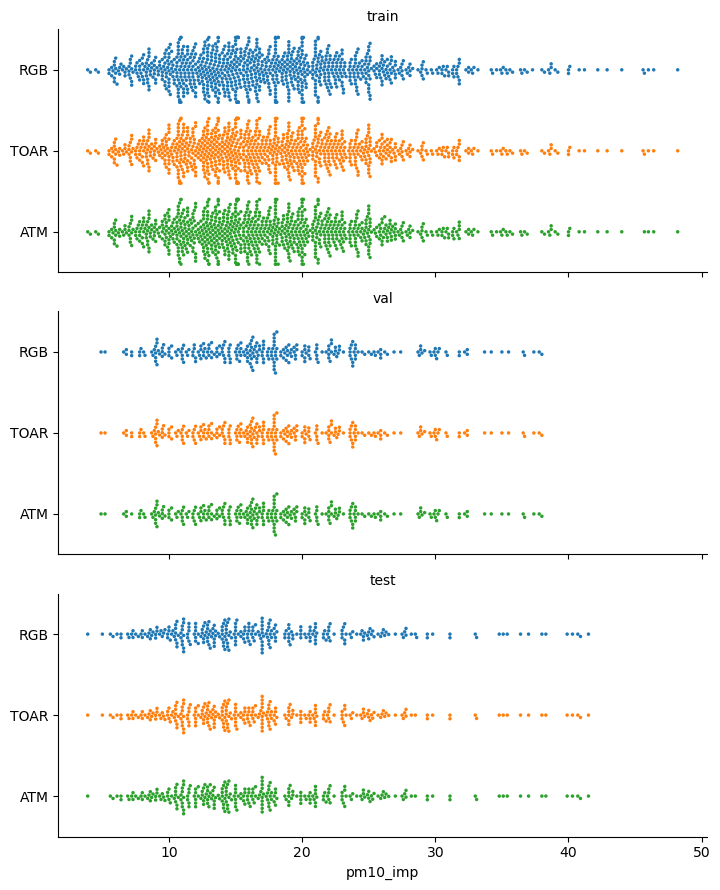

In [9]:
#| label: fig-splits-pm10-noout
#| fig-cap: "Distribution of PM~10~ in uniform splits, excluding PM~10~ > 50 µg/m^3^"

target = "pm10_imp"
p = (
    sns.catplot(
        ps2_split.query(f"{target} < {limits[target]}"),
        x=target,
        y="data_type",
        row="set",
        hue="data_type",
        kind="swarm", size=2.5, aspect=2.5, height=3
    )
    .set_titles("{row_name}")
    .set_axis_labels(y_var="")
)

## OP~AA~

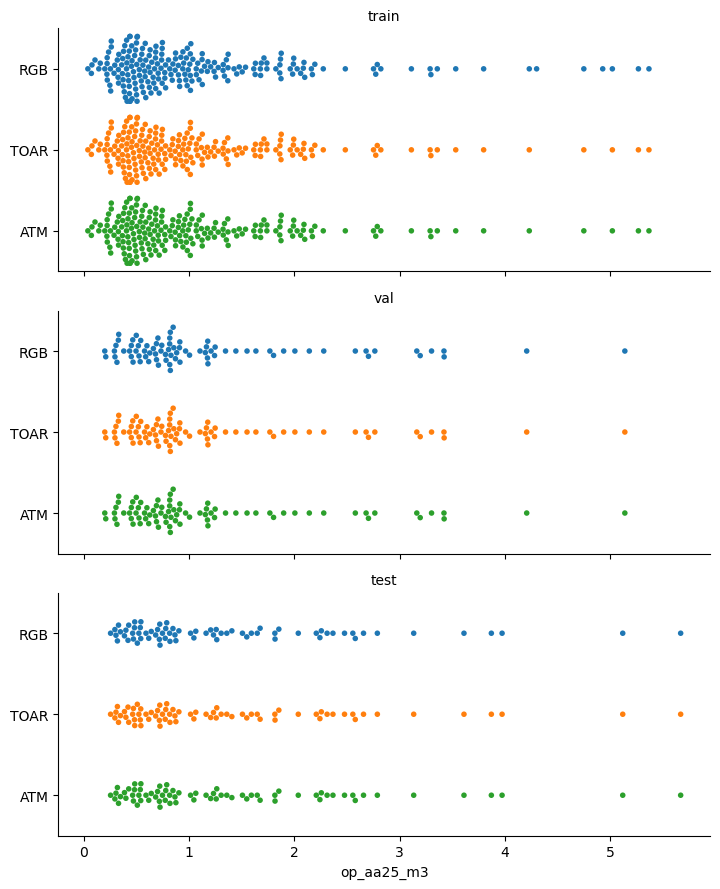

In [10]:
#| label: fig-splits-aa-noout
#| fig-cap: "Distribution of OP~AA~ in uniform splits, excluding OP~AA~ > 6 nmol min^-3^ m^-3^"

target = "op_aa25_m3"
p = (
    sns.catplot(
        ps2_split.query(f"{target} < {limits[target]}"),
        x=target,
        y="data_type",
        row="set",
        hue="data_type",
        kind="swarm", size=4, aspect=2.5, height=3
    )
    .set_titles("{row_name}")
    .set_axis_labels(y_var="")
)

## OP~DTT~

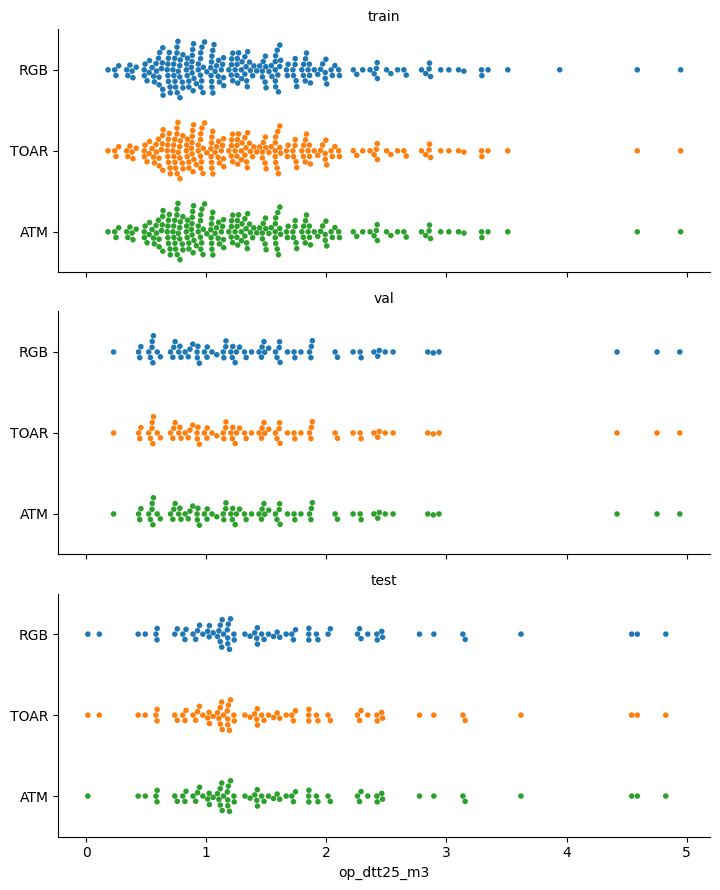

In [11]:
#| label: fig-splits-dtt-noout
#| fig-cap: "Distribution of OP~DTT~ in uniform splits, excluding OP~DTT~ > 5 nmol min^-3^ m^-3^"

target = "op_dtt25_m3"
p = (
    sns.catplot(
        ps2_split.query(f"{target} < {limits[target]}"),
        x=target,
        y="data_type",
        row="set",
        hue="data_type",
        kind="swarm", size=4, aspect=2.5, height=3
    )
    .set_titles("{row_name}")
    .set_axis_labels(y_var="")
)

# Alternate splits

To evaluate the sensitivity of the model and performance metrics to different train / val / test splits we also generate an alternate set of splits.

To focus on the data used to train CNN models, we only show air quality measures for which there is a clear `PS2` image.

@fig-splits2-pm10-noout, @fig-splits2-aa-noout, and @fig-splits2-dtt-noout show the distribution of air quality measures across the alternate train, val, and test sets after excluding outliers.

In [12]:
splits2 = make_splits(
    labels=db_labels,
    test_frac=0.2,
    val_frac=0.2,
    shuffle=True,
    groups="date",
    rand_seed=0 if SEED != 0 else 1,
)
ps2_split2 = ps2_split.drop(columns="set").join(splits2, on=["date", "station"])

## PM~10~

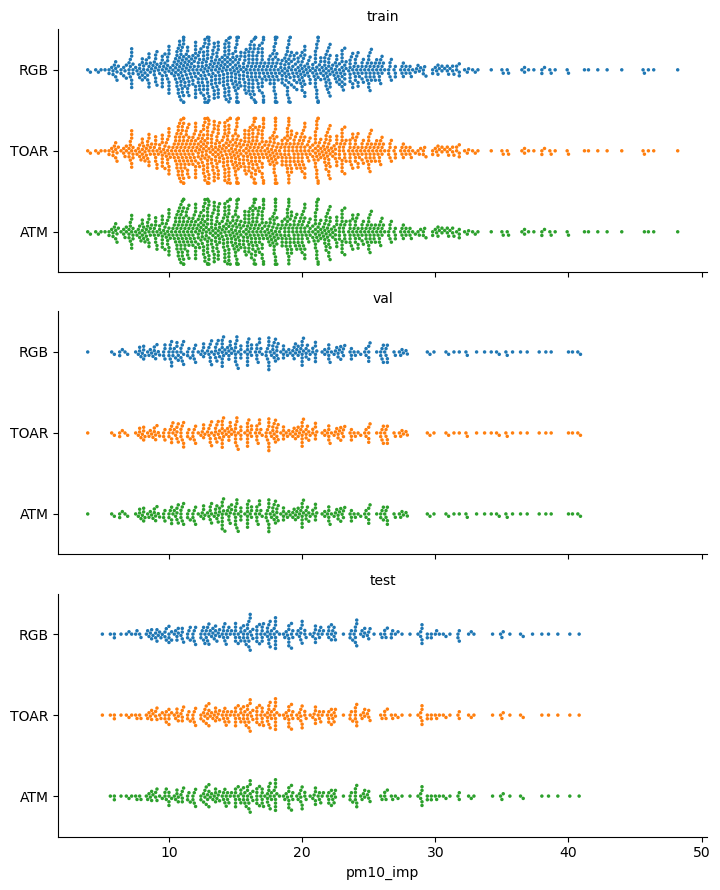

In [13]:
#| label: fig-splits2-pm10-noout
#| fig-cap: "Distribution of PM~10~ in alternate splits, excluding PM~10~ > 50 µg/m^3^"

target = "pm10_imp"
p = (
    sns.catplot(
        ps2_split2.query(f"{target} < {limits[target]}"),
        x=target,
        y="data_type",
        row="set",
        hue="data_type",
        kind="swarm", size=2.5, aspect=2.5, height=3
    )
    .set_titles("{row_name}")
    .set_axis_labels(y_var="")
)

## OP~AA~

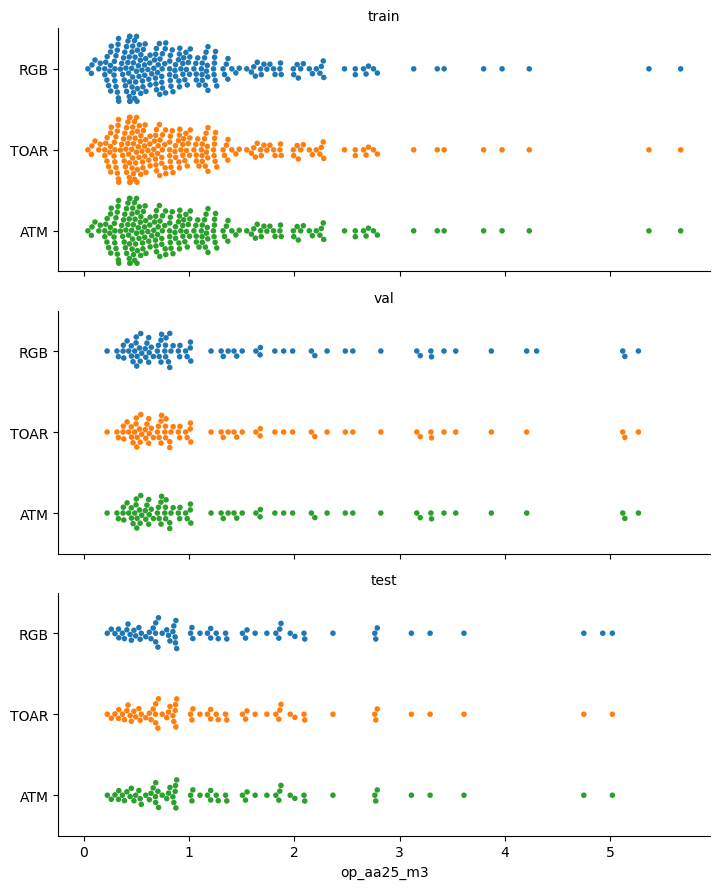

In [14]:
#| label: fig-splits2-aa-noout
#| fig-cap: "Distribution of OP~AA~ in alternate splits, excluding OP~AA~ > 6 nmol min^-3^ m^-3^"

target = "op_aa25_m3"
p = (
    sns.catplot(
        ps2_split2.query(f"{target} < {limits[target]}"),
        x=target,
        y="data_type",
        row="set",
        hue="data_type",
        kind="swarm", size=4, aspect=2.5, height=3
    )
    .set_titles("{row_name}")
    .set_axis_labels(y_var="")
)

## OP~DTT~

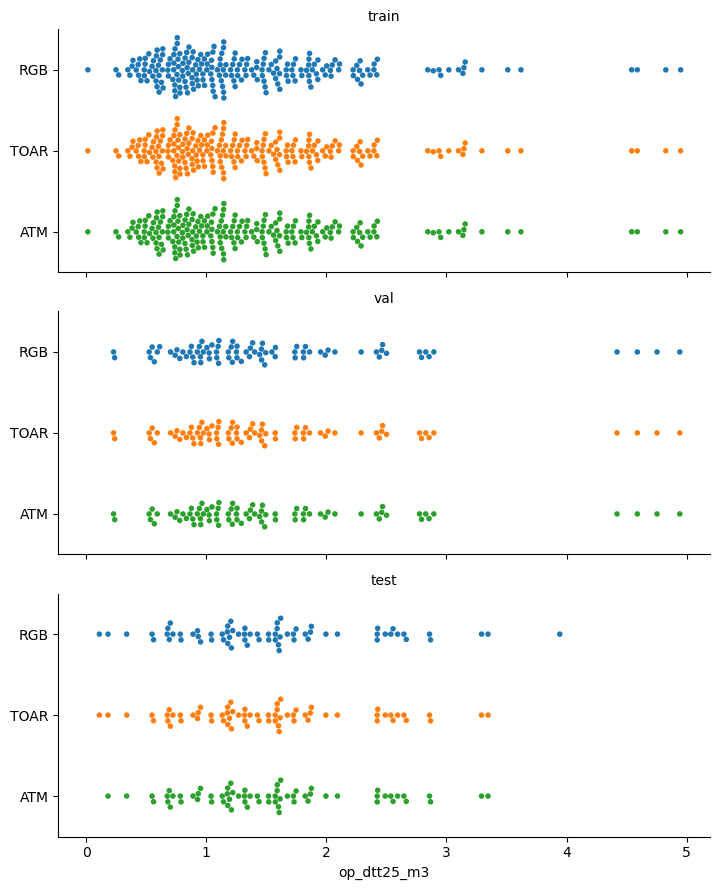

In [15]:
#| label: fig-splits2-dtt-noout
#| fig-cap: "Distribution of OP~DTT~ in alternate splits, excluding OP~DTT~ > 6 nmol min^-3^ m^-3^"

target = "op_dtt25_m3"
p = (
    sns.catplot(
        ps2_split2.query(f"{target} < {limits[target]}"),
        x=target,
        y="data_type",
        row="set",
        hue="data_type",
        kind="swarm", size=4, aspect=2.5, height=3
    )
    .set_titles("{row_name}")
    .set_axis_labels(y_var="")
)

# Train only `GRE-fr`

We also generate a set of splits where only data from `GRE-fr` is used for training and validation, and all data from `GRE-cb` and `VIF` is used for testing. The val data for this set of splits consists of only the main splits' `GRE-fr` val data.

@fig-splits-fr-pm10, @fig-splits-fr-aa, and @fig-splits-fr-dtt show the distribution of air quality measures across the alternate train, val, and test sets after excluding outliers.

In [16]:
splits_fr = splits.reset_index()
splits_fr.loc[splits_fr["station"].eq("GRE-fr") & splits_fr["set"].eq("test"), "set"] = "train"
splits_fr.loc[splits_fr["station"].ne("GRE-fr"), "set"] = "test"
splits_fr = splits_fr.set_index(["date", "station"])
ps2_split_fr = ps2_split.drop(columns="set").join(splits_fr, on=["date", "station"])

## PM~10~

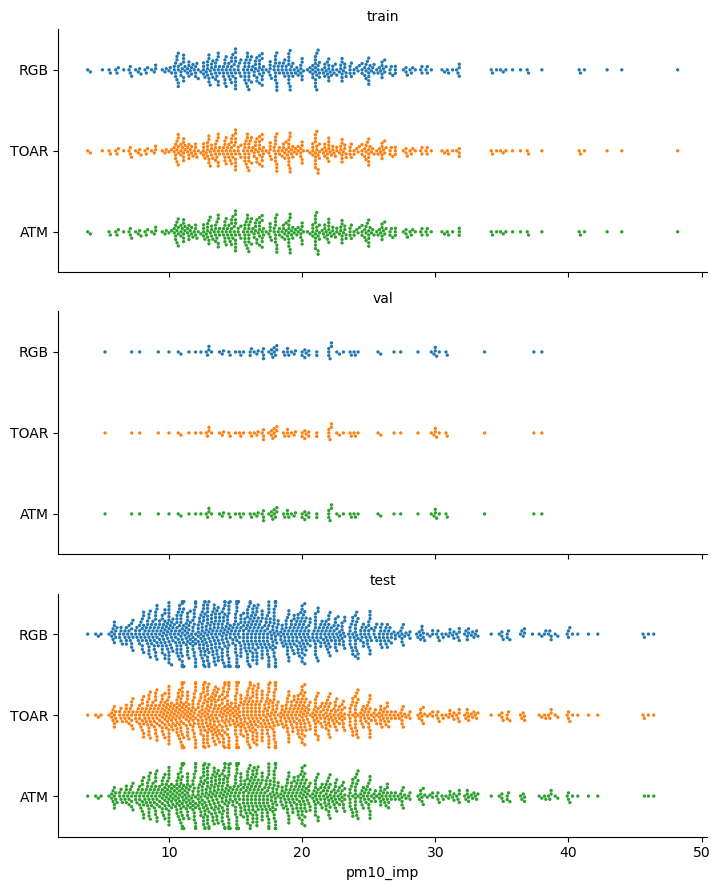

In [17]:
#| label: fig-splits-fr-pm10
#| fig-cap: "Distribution of PM~10~ in `GRE-fr` splits, excluding PM~10~ > 50 µg/m^3^"

target = "pm10_imp"
p = (
    sns.catplot(
        ps2_split_fr.query(f"{target} < {limits[target]}"),
        x=target,
        y="data_type",
        row="set",
        hue="data_type",
        kind="swarm", size=2.4, aspect=2.5, height=3
    )
    .set_titles("{row_name}")
    .set_axis_labels(y_var="")
)

## OP~AA~

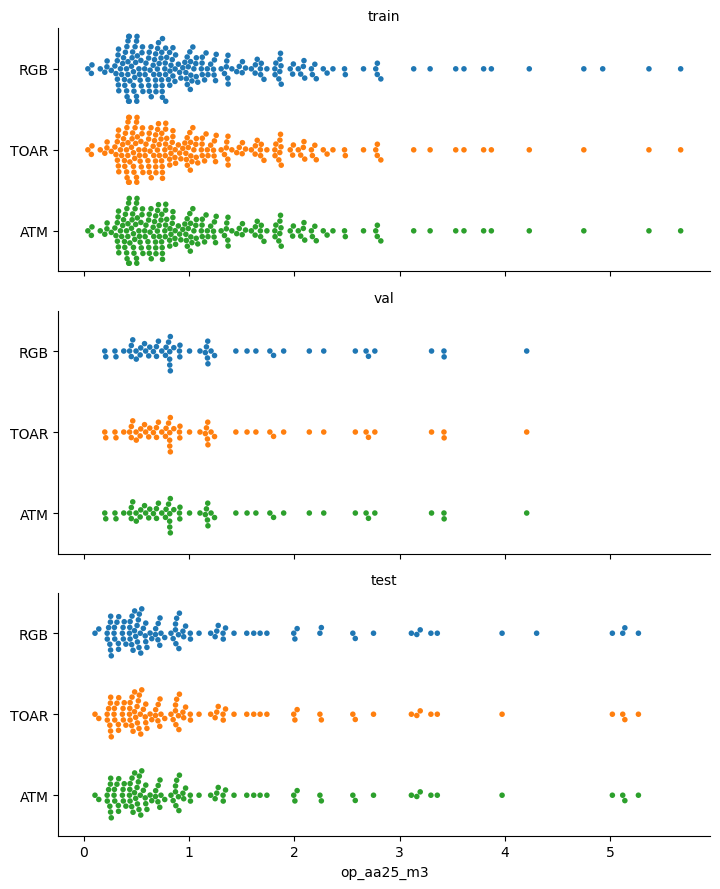

In [18]:
#| label: fig-splits-fr-aa
#| fig-cap: "Distribution of OP~AA~ in `GRE-fr` splits, excluding OP~AA~ > 6 nmol min^-3^ m^-3^"

target = "op_aa25_m3"
p = (
    sns.catplot(
        ps2_split_fr.query(f"{target} < {limits[target]}"),
        x=target,
        y="data_type",
        row="set",
        hue="data_type",
        kind="swarm", size=4, aspect=2.5, height=3
    )
    .set_titles("{row_name}")
    .set_axis_labels(y_var="")
)

## OP~DTT~

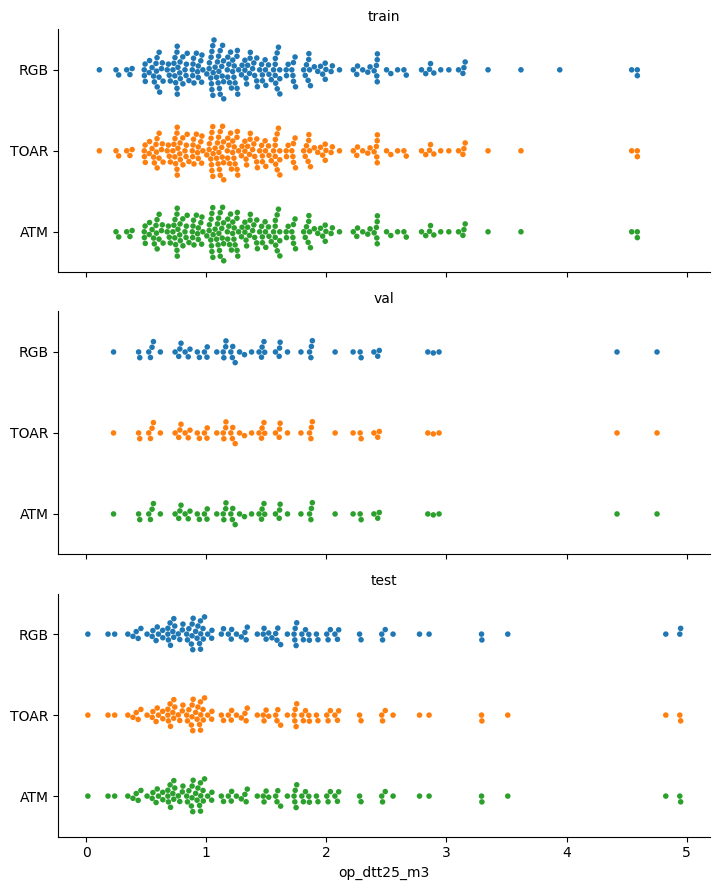

In [19]:
#| label: fig-splits-fr-dtt
#| fig-cap: "Distribution of OP~DTT~ in `GRE-fr` splits, excluding OP~DTT~ > 5 nmol min^-3^ m^-3^"

target = "op_dtt25_m3"
p = (
    sns.catplot(
        ps2_split_fr.query(f"{target} < {limits[target]}"),
        x=target,
        y="data_type",
        row="set",
        hue="data_type",
        kind="swarm", size=4, aspect=2.5, height=3
    )
    .set_titles("{row_name}")
    .set_axis_labels(y_var="")
)